In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py


In [2]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/my_dataset/shuffled_preprocessed_flight_data_100k.csv")
display(df.head())

,year,month,day_of_month,day_of_week,fl_date,op_unique_carrier,op_carrier_fl_num,origin,origin_city_name,origin_state_nm,...,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,is_dep_delayed,is_arr_delayed
0,2024,4,19,5,2024-04-19,AA,2491.0,STT,"Charlotte Amalie, VI",U.S. Virgin Islands,...,184.0,163.0,1107.0,0,0,0,0,0,False,False
1,2024,5,20,1,2024-05-20,UA,1321.0,EWR,"Newark, NJ",New Jersey,...,189.0,149.0,1085.0,0,0,0,0,0,False,False
2,2024,7,9,2,2024-07-09,WN,3613.0,HOU,"Houston, TX",Texas,...,53.0,38.0,192.0,0,0,0,0,26,True,True
3,2024,9,24,2,2024-09-24,AS,453.0,IAH,"Houston, TX",Texas,...,284.0,252.0,1874.0,0,0,0,0,0,False,False
4,2024,5,31,5,2024-05-31,AA,2847.0,LGA,"New York, NY",New York,...,222.0,185.0,1389.0,0,0,0,0,0,True,True


In [3]:
print(len(df))

100000


In [4]:
from typing import Tuple, List


FEATURES = [
    "month",
    "day_of_month",
    "day_of_week",
    "op_unique_carrier",
    "origin",
    "origin_city_name",
    "origin_state_nm",
    "dest",
    "dest_city_name",
    "dest_state_nm",
    "dep_time",
    "distance"
]

TARGET = "is_arr_delayed"


def load_preprocessed_data(df, features: List[str] = FEATURES) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Load the preprocessed flight data CSV and return X (features DataFrame) and y (target Series).

    This function returns the selected feature columns and the target column as-is from the
    preprocessed CSV. It does not perform any encoding or scaling — that should be handled by
    the caller so that preprocessing choices remain explicit.

    Parameters:
        path: Path to the preprocessed CSV file (default: ./data/preprocessed_flight_data.csv)
        features: List of feature column names to select (default: FEATURES)

    Returns:
        X: pd.DataFrame with selected feature columns (numeric)
        y: pd.Series with the target values
    """

    missing = set(features + [TARGET]) - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}")

    X = df[features]
    y = df[TARGET]
    return X, y


__all__ = ["load_preprocessed_data", "FEATURES", "TARGET"]


In [5]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt


def evaluate_model(model, X_test, y_test):
    """
    Evaluate a classification model and return evaluation metrics.

    Parameters:
        model: Trained model with a predict_proba or predict method.
        X_test: Test features.
        y_test: True labels for the test set.

    Returns:
        metrics: Dictionary containing accuracy, classification report, confusion matrix, and AUC scores.
    """
    try:
      y_scores = model.predict_proba(X_test)[:, 1]
    except AttributeError:
      try:
          y_scores = model.decision_function(X_test)
      except AttributeError:
          y_scores = model.predict(X_test)

    # Final predictions (binary)
    y_pred = model.predict(X_test)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # ROC and PR curves
    try:
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)

        precision, recall, _ = precision_recall_curve(y_test, y_scores)
        pr_auc = auc(recall, precision)
    except:
        fpr, tpr, roc_auc = None, None, None
        precision, recall, pr_auc = None, None, None

    # Plot curves if available
    if fpr is not None and recall is not None:
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, color='blue', label=f'ROC AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')

        plt.subplot(1, 2, 2)
        plt.plot(recall, precision, color='green', label=f'PR AUC = {pr_auc:.2f}')
        plt.title('Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc='lower left')

        plt.tight_layout()
        plt.show()

    metrics = {
        'accuracy': accuracy,
        'classification_report': class_report,
        'confusion_matrix': conf_matrix,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    }

    return metrics



def compare_models(models, X_test, y_test):
    """
    Compare multiple classification models using evaluation metrics.

    Parameters:
        models: List of tuples (model_name, model).
        X_test: Test features.
        y_test: True labels for the test set.

    Returns:
        comparison: Dictionary containing evaluation metrics for each model.
    """
    comparison = {}

    for model_name, model in models:
        print(f"Evaluating model: {model_name}")
        metrics = evaluate_model(model, X_test, y_test)
        comparison[model_name] = metrics

    return comparison

In [6]:
import cuml
from cuml.svm import LinearSVC
from cuml.model_selection import train_test_split
import cupy as cp
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

X, Y = load_preprocessed_data(df)

X = X[:50000]
Y = Y[:50000]

categorical_columns = X.select_dtypes(include=['object']).columns

for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

X_processed = X.to_numpy()
print("Preprocessed X shape:", X_processed.shape)

from cuml.preprocessing import StandardScaler

scaler = StandardScaler()
X_processed = scaler.fit_transform(X_processed)



Preprocessed X shape: (50000, 12)


**Selection of best number of variables**

In [7]:
# k for linear
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, average_precision_score

X_train, X_test, Y_train, Y_test = train_test_split(X_processed, Y, test_size=0.2, random_state=42)
X_train_np = cp.asnumpy(X_train)
X_test_np = cp.asnumpy(X_test)
Y_train_np = cp.asnumpy(Y_train)
Y_test_np = cp.asnumpy(Y_test)


vt = VarianceThreshold(threshold=0.0)
X_train_np = vt.fit_transform(X_train_np)
X_test_np = vt.transform(X_test_np)

for k in [2, 4, 6, 8, 10, 12]:
  selector = SelectKBest(score_func=f_classif, k=k)
  X_train_selected = selector.fit_transform(X_train_np, Y_train_np)
  X_test_selected = selector.transform(X_test_np)

  clf = LinearSVC(class_weight='balanced')
  clf.fit(X_train_selected, Y_train_np)

  Y_pred = clf.predict(X_test_selected)
  scores = clf.decision_function(X_test_selected)

  acc = accuracy_score(Y_test_np, Y_pred)
  f1 = f1_score(Y_test_np, Y_pred, average='macro')
  precision = precision_score(Y_test_np, Y_pred, average='macro')
  recall = recall_score(Y_test_np, Y_pred, average='macro')
  roc_auc = roc_auc_score(Y_test_np, scores)

  print(f"k for Linear SVC={k}: Acc={acc:.4f}, F1={f1:.4f}, Prec={precision:.4f}, Recall={recall:.4f}, ROC_AUC={roc_auc:.4f}")

k for Linear SVC=2: Acc=0.5883, F1=0.5793, Prec=0.5847, Recall=0.5910, ROC_AUC=0.6215
k for Linear SVC=4: Acc=0.5856, F1=0.5763, Prec=0.5816, Recall=0.5876, ROC_AUC=0.6232
k for Linear SVC=6: Acc=0.5879, F1=0.5787, Prec=0.5839, Recall=0.5901, ROC_AUC=0.6240
k for Linear SVC=8: Acc=0.5887, F1=0.5791, Prec=0.5838, Recall=0.5900, ROC_AUC=0.6245
k for Linear SVC=10: Acc=0.5887, F1=0.5793, Prec=0.5842, Recall=0.5905, ROC_AUC=0.6252
k for Linear SVC=12: Acc=0.5889, F1=0.5796, Prec=0.5847, Recall=0.5911, ROC_AUC=0.6249


In [8]:
selector = SelectKBest(score_func=f_classif, k=4)
X_selected_linear = selector.fit_transform(X_processed, Y)
selected_indices = selector.get_support(indices=True)
selected_feature_names = X.columns[selected_indices]
print("Selected Features:", selected_feature_names)


Selected Features: Index(['month', 'day_of_week', 'origin_city_name', 'dep_time'], dtype='object')


In [9]:
from cuml.svm import SVC
# k for SVC
for k in [2, 4, 6, 8, 10, 12]:
  selector = SelectKBest(score_func=f_classif, k=k)
  X_train_selected = selector.fit_transform(X_train_np, Y_train_np)
  X_test_selected = selector.transform(X_test_np)

  clf = SVC(class_weight='balanced', random_state=42)
  clf.fit(X_train_selected, Y_train_np)

  Y_pred = clf.predict(X_test_selected)
  scores = clf.decision_function(X_test_selected)

  acc = accuracy_score(Y_test_np, Y_pred)
  f1 = f1_score(Y_test_np, Y_pred, average='macro')
  precision = precision_score(Y_test_np, Y_pred, average='macro')
  recall = recall_score(Y_test_np, Y_pred, average='macro')
  roc_auc = roc_auc_score(Y_test_np, scores)

  print(f"k for SVC={k}: Acc={acc:.4f}, F1={f1:.4f}, Prec={precision:.4f}, Recall={recall:.4f}, ROC_AUC={roc_auc:.4f}")

k for SVC=2: Acc=0.5910, F1=0.5826, Prec=0.5885, Recall=0.5952, ROC_AUC=0.6298
k for SVC=4: Acc=0.5967, F1=0.5894, Prec=0.5964, Recall=0.6037, ROC_AUC=0.6385
k for SVC=6: Acc=0.5963, F1=0.5874, Prec=0.5927, Recall=0.5996, ROC_AUC=0.6372
k for SVC=8: Acc=0.5952, F1=0.5860, Prec=0.5909, Recall=0.5977, ROC_AUC=0.6327
k for SVC=10: Acc=0.6043, F1=0.5937, Prec=0.5970, Recall=0.6040, ROC_AUC=0.6362
k for SVC=12: Acc=0.6038, F1=0.5937, Prec=0.5973, Recall=0.6044, ROC_AUC=0.6375


In [10]:
selector = SelectKBest(score_func=f_classif, k=4)
X_selected_rbf = selector.fit_transform(X_processed, Y)
selected_indices = selector.get_support(indices=True)
selected_feature_names = X.columns[selected_indices]
print("Selected Features:", selected_feature_names)


Selected Features: Index(['month', 'day_of_week', 'origin_city_name', 'dep_time'], dtype='object')


**Linear SVC**

In [11]:
X_gpu = cp.asarray(X_selected_linear)
Y_gpu = cp.asarray(Y, dtype=cp.float32)

X_train, X_test, Y_train, Y_test = train_test_split(X_gpu, Y_gpu, test_size=0.2, random_state=42)

clf = LinearSVC(class_weight='balanced', probability=True)
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)
accuracy = cp.mean(Y_pred == Y_test)
print("Accuracy:", accuracy.item())

Accuracy: 0.5856


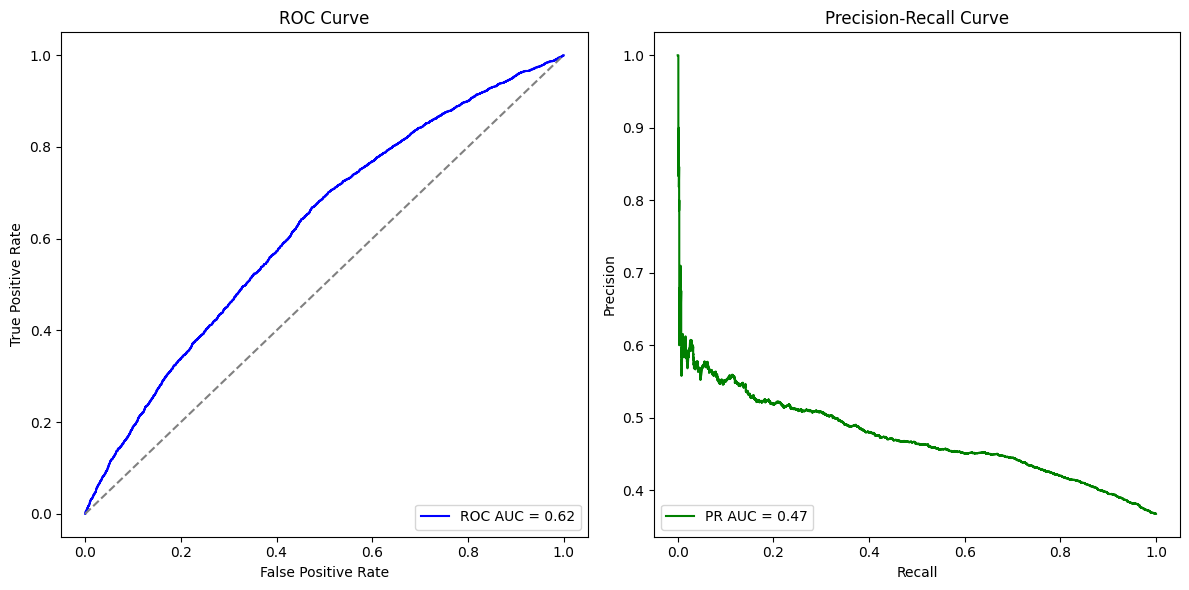

{'accuracy': 0.5856, 'classification_report': {'0.0': {'precision': 0.7115421920465568, 'recall': 0.5799209486166008, 'f1-score': 0.6390243902439025, 'support': 6325.0}, '1.0': {'precision': 0.4515995872033024, 'recall': 0.5953741496598639, 'f1-score': 0.5136150234741784, 'support': 3675.0}, 'accuracy': 0.5856, 'macro avg': {'precision': 0.5815708896249296, 'recall': 0.5876475491382324, 'f1-score': 0.5763197068590404, 'support': 10000.0}, 'weighted avg': {'precision': 0.6160132847666607, 'recall': 0.5856, 'f1-score': 0.5929364479560288, 'support': 10000.0}}, 'confusion_matrix': array([[3668, 2657],
       [1487, 2188]]), 'roc_auc': np.float64(0.6232171224220913), 'pr_auc': np.float64(0.47283648862449595)}


In [12]:
metrics = evaluate_model(clf, X_test.get(), Y_test.get())
print(metrics)

**SVC rbf kernel**

In [13]:
from cuml.svm import SVC
X_gpu = cp.asarray(X_selected_rbf)
Y_gpu = cp.asarray(Y, dtype=cp.float32)

X_train, X_test, Y_train, Y_test = train_test_split(X_gpu, Y_gpu, test_size=0.2, random_state=42)

clf = SVC(class_weight='balanced', random_state=42)
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)
accuracy = cp.mean(Y_pred == Y_test)
print("Accuracy:", accuracy.item())

Accuracy: 0.5967


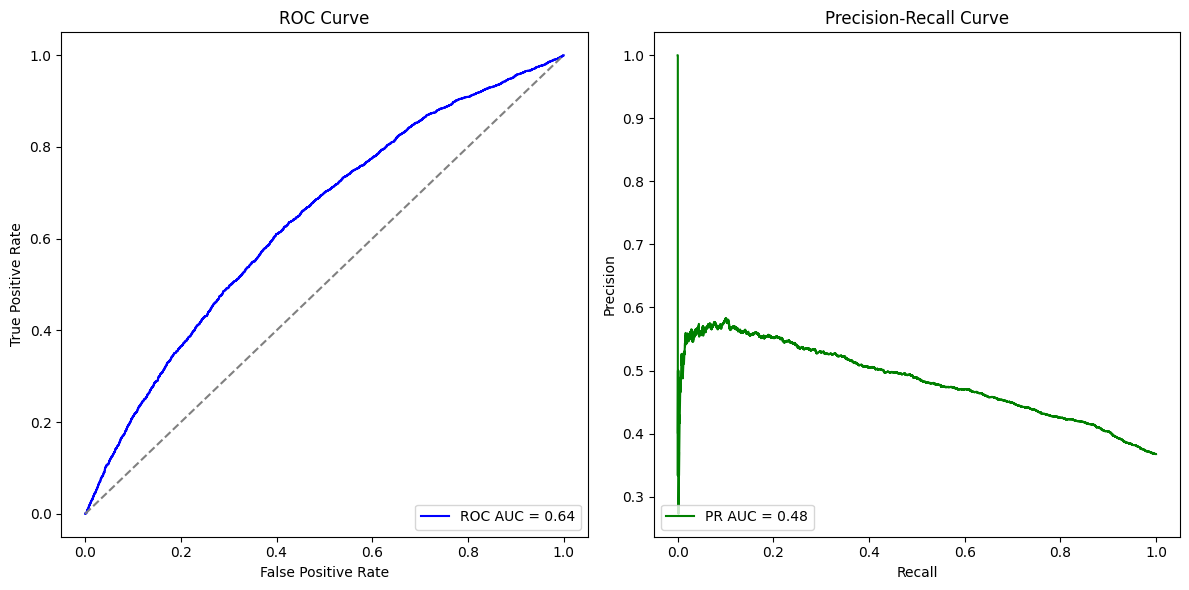

{'accuracy': 0.5967, 'classification_report': {'0.0': {'precision': 0.7286512370311253, 'recall': 0.577391304347826, 'f1-score': 0.6442621504807268, 'support': 6325.0}, '1.0': {'precision': 0.4641138732959102, 'recall': 0.6299319727891156, 'f1-score': 0.5344568856054485, 'support': 3675.0}, 'accuracy': 0.5967, 'macro avg': {'precision': 0.5963825551635178, 'recall': 0.6036616385684708, 'f1-score': 0.5893595180430876, 'support': 10000.0}, 'weighted avg': {'precision': 0.6314337558584338, 'recall': 0.5967, 'f1-score': 0.603908715639062, 'support': 10000.0}}, 'confusion_matrix': array([[3652, 2673],
       [1360, 2315]]), 'roc_auc': np.float64(0.6385089080691566), 'pr_auc': np.float64(0.48397553691842754)}


In [14]:
metrics = evaluate_model(clf, X_test.get(), Y_test.get())
print(metrics)

**SVC sigmoid kernel**

In [15]:
from cuml.svm import SVC
X_gpu = cp.asarray(X_selected_rbf)
Y_gpu = cp.asarray(Y, dtype=cp.float32)

X_train, X_test, Y_train, Y_test = train_test_split(X_gpu, Y_gpu, test_size=0.2, random_state=42)

clf = SVC(kernel="sigmoid", class_weight='balanced', random_state=42)
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)
accuracy = cp.mean(Y_pred == Y_test)
print("Accuracy:", accuracy.item())

Accuracy: 0.5194


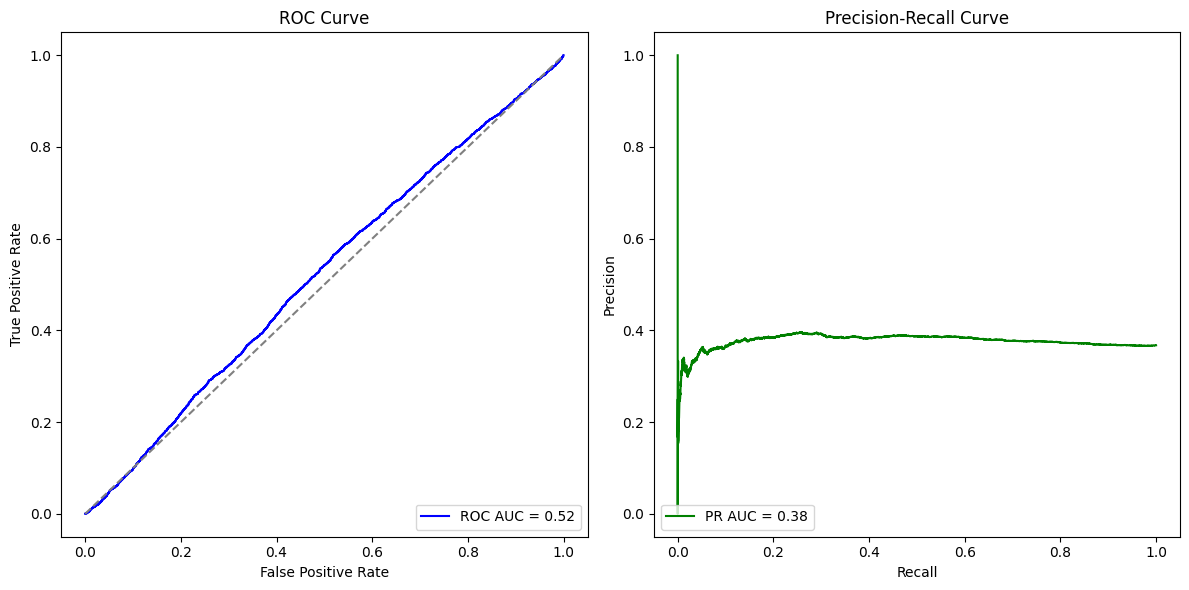

{'accuracy': 0.5194, 'classification_report': {'0.0': {'precision': 0.6510240604493935, 'recall': 0.5176284584980237, 'f1-score': 0.576713052668663, 'support': 6325.0}, '1.0': {'precision': 0.38624019312009655, 'recall': 0.5224489795918368, 'f1-score': 0.4441360166551006, 'support': 3675.0}, 'accuracy': 0.5194, 'macro avg': {'precision': 0.518632126784745, 'recall': 0.5200387190449303, 'f1-score': 0.5104245346618819, 'support': 10000.0}, 'weighted avg': {'precision': 0.553715989205877, 'recall': 0.5194, 'f1-score': 0.5279909919336788, 'support': 10000.0}}, 'confusion_matrix': array([[3274, 3051],
       [1755, 1920]]), 'roc_auc': np.float64(0.5204678336156597), 'pr_auc': np.float64(0.3760520555424229)}


In [16]:
metrics = evaluate_model(clf, X_test.get(), Y_test.get())
print(metrics)

**SVC polynomial kernel**

In [17]:
from cuml.svm import SVC
X_gpu = cp.asarray(X_selected_rbf)
Y_gpu = cp.asarray(Y, dtype=cp.float32)

X_train, X_test, Y_train, Y_test = train_test_split(X_gpu, Y_gpu, test_size=0.2, random_state=42)

clf = SVC(kernel="poly", class_weight='balanced', random_state=42)
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)
accuracy = cp.mean(Y_pred == Y_test)
print("Accuracy:", accuracy.item())

Accuracy: 0.5946


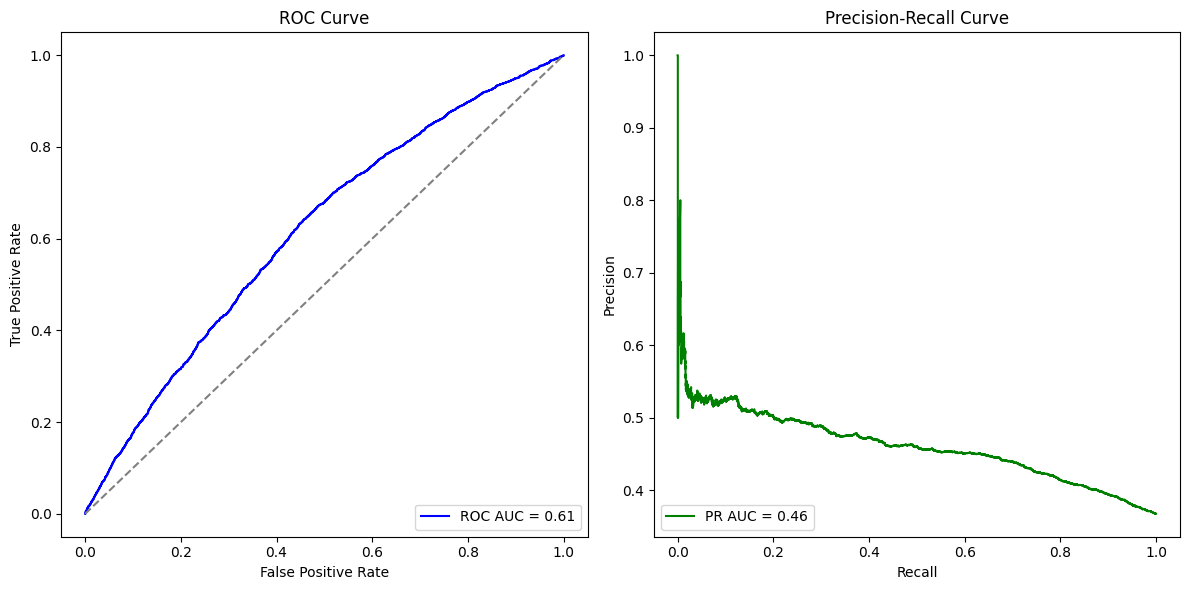

{'accuracy': 0.5946, 'classification_report': {'0.0': {'precision': 0.6994554716318285, 'recall': 0.6295652173913043, 'f1-score': 0.6626726576801465, 'support': 6325.0}, '1.0': {'precision': 0.4560018574413745, 'recall': 0.534421768707483, 'f1-score': 0.49210724129290906, 'support': 3675.0}, 'accuracy': 0.5946, 'macro avg': {'precision': 0.5777286645366015, 'recall': 0.5819934930493937, 'f1-score': 0.5773899494865278, 'support': 10000.0}, 'weighted avg': {'precision': 0.6099862684168367, 'recall': 0.5946, 'f1-score': 0.5999898671578368, 'support': 10000.0}}, 'confusion_matrix': array([[3982, 2343],
       [1711, 1964]]), 'roc_auc': np.float64(0.6148801806888764), 'pr_auc': np.float64(0.46039675951918213)}


In [18]:
metrics = evaluate_model(clf, X_test.get(), Y_test.get())
print(metrics)

**Best parameters for linear SVC**


In [ ]:
%pip install optuna

In [20]:
import optuna
from optuna.samplers import TPESampler
sampler = TPESampler(seed=42)

X_gpu = cp.asarray(X_selected_linear)
Y_gpu = cp.asarray(Y, dtype=cp.float32)

X_train, X_test, Y_train, Y_test = train_test_split(X_gpu, Y_gpu, test_size=0.2, random_state=42)

def objective(trial):
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
  penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])

  clf = LinearSVC(C=C, penalty=penalty, class_weight='balanced')
  clf.fit(X_train, Y_train)

  Y_pred = clf.predict(X_test)

  Y_pred_np = cp.asnumpy(Y_pred)
  Y_test_np = cp.asnumpy(Y_test)

  recall = recall_score(Y_test_np, Y_pred_np, pos_label=1.0)
  return recall



In [ ]:
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print(f"  Recall: {trial.value}")
print(f"  Params: {trial.params}")

Accuracy: 0.5824


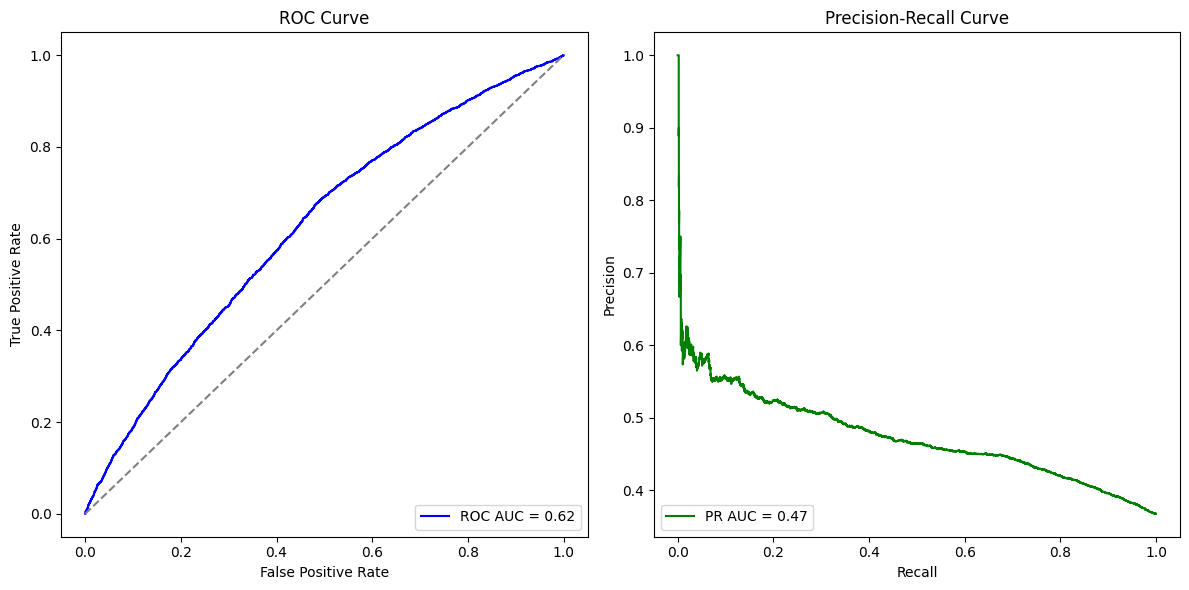

{'accuracy': 0.5824, 'classification_report': {'0.0': {'precision': 0.7152012817945124, 'recall': 0.5645849802371542, 'f1-score': 0.6310302173528892, 'support': 6325.0}, '1.0': {'precision': 0.4499700419412822, 'recall': 0.6130612244897959, 'f1-score': 0.5190048375950241, 'support': 3675.0}, 'accuracy': 0.5824, 'macro avg': {'precision': 0.5825856618678973, 'recall': 0.5888231023634751, 'f1-score': 0.5750175274739566, 'support': 10000.0}, 'weighted avg': {'precision': 0.6177288011484503, 'recall': 0.5824, 'f1-score': 0.5898608902918738, 'support': 10000.0}}, 'confusion_matrix': array([[3571, 2754],
       [1422, 2253]]), 'roc_auc': np.float64(0.623274297545105), 'pr_auc': np.float64(0.4736830058465703)}


In [22]:
from cuml.svm import SVC
X_gpu = cp.asarray(X_selected_linear)
Y_gpu = cp.asarray(Y, dtype=cp.float32)

X_train, X_test, Y_train, Y_test = train_test_split(X_gpu, Y_gpu, test_size=0.2, random_state=42)

test_linear = LinearSVC(C=trial.params['C'], penalty=trial.params['penalty'], class_weight='balanced', probability=True)
test_linear.fit(X_train, Y_train)

Y_pred = test_linear.predict(X_test)
accuracy = cp.mean(Y_pred == Y_test)
print("Accuracy:", accuracy.item())
metrics = evaluate_model(test_linear, X_test.get(), Y_test.get())
print(metrics)

In [ ]:
import optuna.visualization

optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

In [24]:
# best params for weighted recall

X_gpu = cp.asarray(X_selected_linear)
Y_gpu = cp.asarray(Y, dtype=cp.float32)

X_train, X_test, Y_train, Y_test = train_test_split(X_gpu, Y_gpu, test_size=0.2, random_state=42)

def objective(trial):
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
  penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])

  clf = LinearSVC(C=C, penalty=penalty, class_weight='balanced')
  clf.fit(X_train, Y_train)

  Y_pred = clf.predict(X_test)

  Y_pred_np = cp.asnumpy(Y_pred)
  Y_test_np = cp.asnumpy(Y_test)

  recall_0 = recall_score(Y_test_np, Y_pred_np, pos_label=0.0)
  recall_1 = recall_score(Y_test_np, Y_pred_np, pos_label=1.0)
  print("recall 0: ", recall_0, "  recall_1: ", recall_1)

  weighted_recall = 0.1 * recall_0 + 0.9 * recall_1

  return weighted_recall



In [ ]:
# Create study to maximize recall
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

trial = study.best_trial
print("Best trial:")
print("  Value (Recall - weighted):", trial.value)
print("  Params:", trial.params)

Accuracy: 0.5829


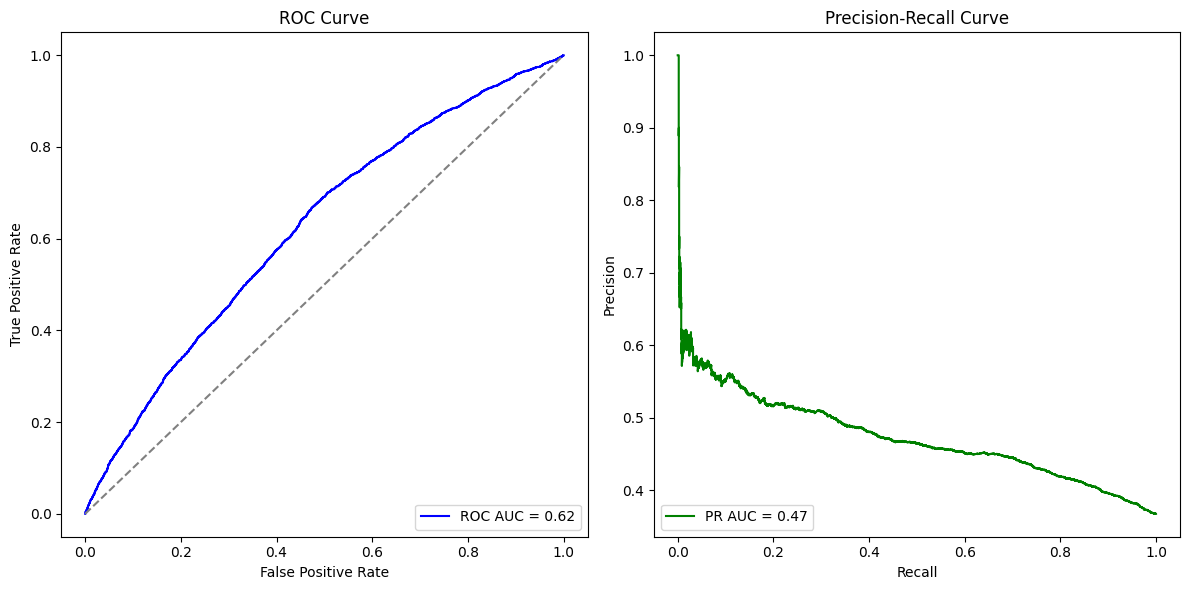

{'accuracy': 0.5829, 'classification_report': {'0.0': {'precision': 0.7157451923076923, 'recall': 0.564901185770751, 'f1-score': 0.631439427410091, 'support': 6325.0}, '1.0': {'precision': 0.4504792332268371, 'recall': 0.6138775510204082, 'f1-score': 0.5196360704825521, 'support': 3675.0}, 'accuracy': 0.5829, 'macro avg': {'precision': 0.5831122127672647, 'recall': 0.5893893683955795, 'f1-score': 0.5755377489463216, 'support': 10000.0}, 'weighted avg': {'precision': 0.618259952345478, 'recall': 0.5829, 'f1-score': 0.5903516937392205, 'support': 10000.0}}, 'confusion_matrix': array([[3573, 2752],
       [1419, 2256]]), 'roc_auc': np.float64(0.6232702535559679), 'pr_auc': np.float64(0.4733964530451946)}


In [26]:
from cuml.svm import SVC
X_gpu = cp.asarray(X_selected_linear)
Y_gpu = cp.asarray(Y, dtype=cp.float32)

X_train, X_test, Y_train, Y_test = train_test_split(X_gpu, Y_gpu, test_size=0.2, random_state=42)

test_linear = LinearSVC(C=trial.params['C'], penalty=trial.params['penalty'], class_weight='balanced', probability=True)
test_linear.fit(X_train, Y_train)

Y_pred = test_linear.predict(X_test)
accuracy = cp.mean(Y_pred == Y_test)
print("Accuracy:", accuracy.item())
metrics = evaluate_model(test_linear, X_test.get(), Y_test.get())
print(metrics)


In [27]:
# using f1 score

X_gpu = cp.asarray(X_selected_linear)
Y_gpu = cp.asarray(Y, dtype=cp.float32)

X_train, X_test, Y_train, Y_test = train_test_split(X_gpu, Y_gpu, test_size=0.2, random_state=42)

def objective(trial):
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
  penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])

  clf = LinearSVC(C=C, penalty=penalty, class_weight='balanced')
  clf.fit(X_train, Y_train)

  Y_pred = clf.predict(X_test)

  Y_pred_np = cp.asnumpy(Y_pred)
  Y_test_np = cp.asnumpy(Y_test)

  f1 = f1_score(Y_test_np, Y_pred_np, pos_label=1)
  return f1



In [ ]:
# Create study to maximize recall
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

trial = study.best_trial
print("Best trial:")
print("  Value (f1 score):", trial.value)
print("  Params:", trial.params)

Accuracy: 0.5824


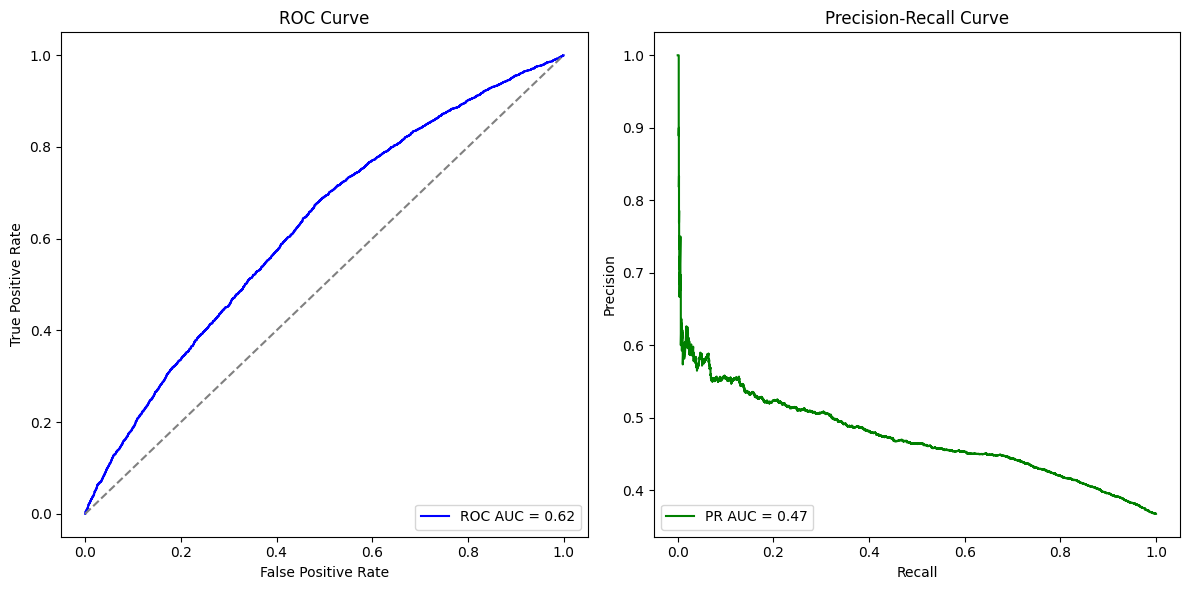

{'accuracy': 0.5824, 'classification_report': {'0.0': {'precision': 0.7152012817945124, 'recall': 0.5645849802371542, 'f1-score': 0.6310302173528892, 'support': 6325.0}, '1.0': {'precision': 0.4499700419412822, 'recall': 0.6130612244897959, 'f1-score': 0.5190048375950241, 'support': 3675.0}, 'accuracy': 0.5824, 'macro avg': {'precision': 0.5825856618678973, 'recall': 0.5888231023634751, 'f1-score': 0.5750175274739566, 'support': 10000.0}, 'weighted avg': {'precision': 0.6177288011484503, 'recall': 0.5824, 'f1-score': 0.5898608902918738, 'support': 10000.0}}, 'confusion_matrix': array([[3571, 2754],
       [1422, 2253]]), 'roc_auc': np.float64(0.623274297545105), 'pr_auc': np.float64(0.47368744163952065)}


In [29]:
from cuml.svm import SVC
X_gpu = cp.asarray(X_selected_linear)
Y_gpu = cp.asarray(Y, dtype=cp.float32)

X_train, X_test, Y_train, Y_test = train_test_split(X_gpu, Y_gpu, test_size=0.2, random_state=42)

test_linear = LinearSVC(C=trial.params['C'], penalty=trial.params['penalty'], class_weight='balanced', probability=True)
test_linear.fit(X_train, Y_train)

Y_pred = test_linear.predict(X_test)
accuracy = cp.mean(Y_pred == Y_test)
print("Accuracy:", accuracy.item())
metrics = evaluate_model(test_linear, X_test.get(), Y_test.get())
print(metrics)


**Best params for SVM with rbf kernel**

In [30]:
import optuna

X_gpu = cp.asarray(X_selected_rbf)
Y_gpu = cp.asarray(Y, dtype=cp.float32)

X_train, X_test, Y_train, Y_test = train_test_split(X_gpu, Y_gpu, test_size=0.2, random_state=42)

def objective(trial):
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)

  clf = SVC(kernel="rbf", C=C, gamma=gamma, class_weight='balanced', random_state=42)
  clf.fit(X_train, Y_train)

  Y_pred = clf.predict(X_test)

  Y_pred_np = cp.asnumpy(Y_pred)
  Y_test_np = cp.asnumpy(Y_test)

  recall = recall_score(Y_test_np, Y_pred_np, pos_label=1.0)
  return recall



In [ ]:
# Create study to maximize recall
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print(f"  Recall: {trial.value}")
print(f"  Params: {trial.params}")

In [ ]:
import optuna.visualization

optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

In [33]:
#RBF with those params:
from cuml.svm import SVC
X_gpu = cp.asarray(X_selected_rbf)
Y_gpu = cp.asarray(Y, dtype=cp.float32)

X_train, X_test, Y_train, Y_test = train_test_split(X_gpu, Y_gpu, test_size=0.2, random_state=42)

clf = SVC(C=trial.params["C"], gamma = trial.params["gamma"], class_weight='balanced', random_state=42)
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)
accuracy = cp.mean(Y_pred == Y_test)
print("Accuracy:", accuracy.item())

Accuracy: 0.3675


In [ ]:
metrics = evaluate_model(clf, X_test.get(), Y_test.get())
print(metrics)

In [35]:
# using weighted recall
import optuna

X_gpu = cp.asarray(X_selected_rbf)
Y_gpu = cp.asarray(Y, dtype=cp.float32)

X_train, X_test, Y_train, Y_test = train_test_split(X_gpu, Y_gpu, test_size=0.2, random_state=42)

def objective(trial):
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)

  clf = SVC(kernel="rbf", C=C, gamma=gamma, class_weight='balanced', random_state=42)
  clf.fit(X_train, Y_train)

  Y_pred = clf.predict(X_test)

  Y_pred_np = cp.asnumpy(Y_pred)
  Y_test_np = cp.asnumpy(Y_test)

  recall_1 = recall_score(Y_test_np, Y_pred_np, pos_label=1.0)
  recall_0 = recall_score(Y_test_np, Y_pred_np, pos_label=0.0)
  weighted_recall = 0.4 * recall_0 + 0.6 * recall_1

  return weighted_recall



In [ ]:
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print("  Value (Recall):", trial.value)
print("  Params:", trial.params)

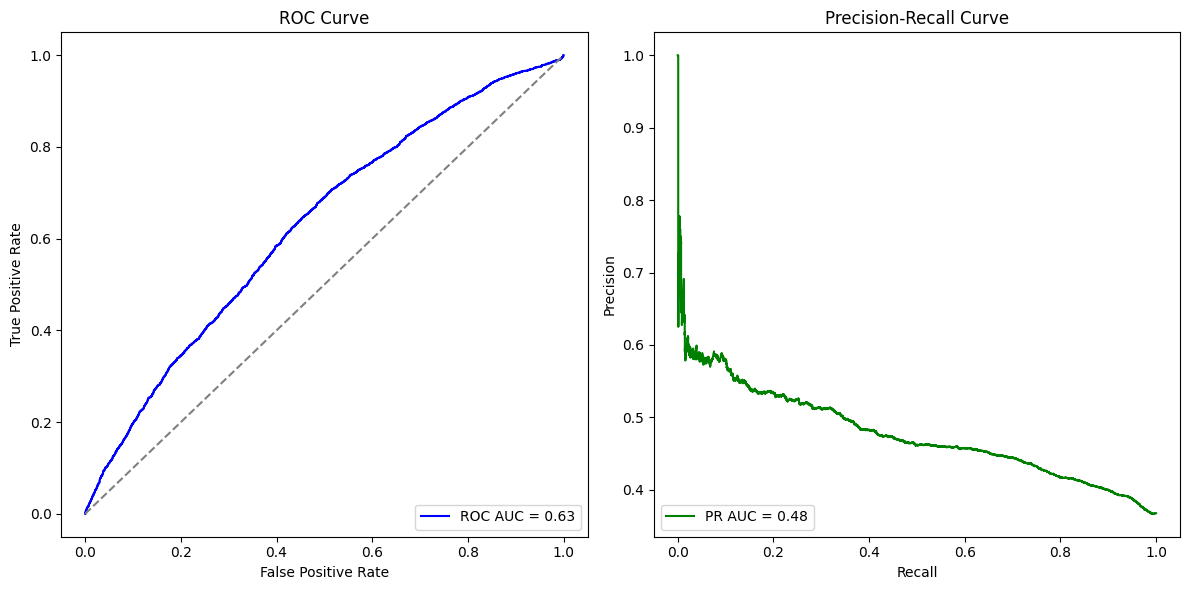

{'accuracy': 0.555, 'classification_report': {'0.0': {'precision': 0.7426870308050738, 'recall': 0.45359683794466404, 'f1-score': 0.5632116215155084, 'support': 6325.0}, '1.0': {'precision': 0.43685839986964314, 'recall': 0.7295238095238096, 'f1-score': 0.5464737056665308, 'support': 3675.0}, 'accuracy': 0.555, 'macro avg': {'precision': 0.5897727153373584, 'recall': 0.5915603237342368, 'f1-score': 0.5548426635910195, 'support': 10000.0}, 'weighted avg': {'precision': 0.630295008936303, 'recall': 0.555, 'f1-score': 0.5570604374410092, 'support': 10000.0}}, 'confusion_matrix': array([[2869, 3456],
       [ 994, 2681]]), 'roc_auc': np.float64(0.6262908553144577), 'pr_auc': np.float64(0.47761535559099694)}


In [37]:
#RBF with those params:
from cuml.svm import SVC
X_gpu = cp.asarray(X_selected_rbf)
Y_gpu = cp.asarray(Y, dtype=cp.float32)

X_train, X_test, Y_train, Y_test = train_test_split(X_gpu, Y_gpu, test_size=0.2, random_state=42)

clf = SVC(C=trial.params["C"], gamma = trial.params["gamma"], class_weight='balanced', random_state=42)
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)
accuracy = cp.mean(Y_pred == Y_test)
metrics = evaluate_model(clf, X_test.get(), Y_test.get())
print(metrics)

In [38]:
#rbf using f-score
import optuna

X_gpu = cp.asarray(X_selected_rbf)
Y_gpu = cp.asarray(Y, dtype=cp.float32)

X_train, X_test, Y_train, Y_test = train_test_split(X_gpu, Y_gpu, test_size=0.2, random_state=42)

def objective(trial):
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)

  clf = SVC(kernel="rbf", C=C, gamma=gamma, class_weight='balanced', random_state=42)
  clf.fit(X_train, Y_train)

  Y_pred = clf.predict(X_test)

  Y_pred_np = cp.asnumpy(Y_pred)
  Y_test_np = cp.asnumpy(Y_test)

  f1 = f1_score(Y_test_np, Y_pred_np, pos_label=1)
  return f1




In [ ]:
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print("  Value (F1 score):", trial.value)
print("  Params:", trial.params)

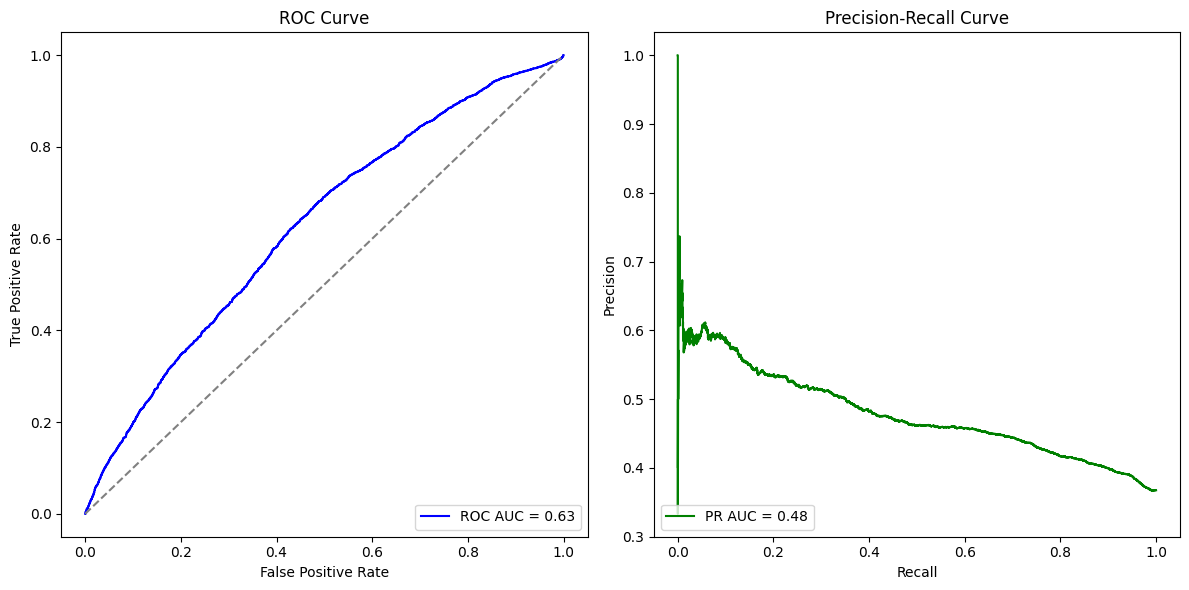

{'accuracy': 0.554, 'classification_report': {'0.0': {'precision': 0.7452011569813305, 'recall': 0.44806324110671936, 'f1-score': 0.5596366508688784, 'support': 6325.0}, '1.0': {'precision': 0.4366629014039051, 'recall': 0.7363265306122448, 'f1-score': 0.5482171799027553, 'support': 3675.0}, 'accuracy': 0.554, 'macro avg': {'precision': 0.5909320291926178, 'recall': 0.5921948858594821, 'f1-score': 0.5539269153858168, 'support': 10000.0}, 'weighted avg': {'precision': 0.6318133480566266, 'recall': 0.554, 'f1-score': 0.5554399952888281, 'support': 10000.0}}, 'confusion_matrix': array([[2834, 3491],
       [ 969, 2706]]), 'roc_auc': np.float64(0.6265406791965797), 'pr_auc': np.float64(0.47802072008954866)}


In [40]:
#RBF with those params:
from cuml.svm import SVC
X_gpu = cp.asarray(X_selected_rbf)
Y_gpu = cp.asarray(Y, dtype=cp.float32)

X_train, X_test, Y_train, Y_test = train_test_split(X_gpu, Y_gpu, test_size=0.2, random_state=42)

clf = SVC(C=trial.params["C"], gamma = trial.params["gamma"], class_weight='balanced', random_state=42)
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)
accuracy = cp.mean(Y_pred == Y_test)
metrics = evaluate_model(clf, X_test.get(), Y_test.get())
print(metrics)